# CS-6600 Homework 5 - XGBoost and Hyperparameter Search

*Weber State University*

**Your Name**: Belal Glab



For this assignment we'll be exploring another *boosting* algorithm like AdaBoost and Gradient Boost - XGBoost. XGBoost is similar to gradient boost in its approach, but a bit more mathematically complicated. More mathematically complicated that we'll need to get into here, but if you're curious you can check out:

* [XGBoost: A Scalable Tree Boosting System](https://arxiv.org/abs/1603.02754)
* [XGBoost Video Series](https://youtu.be/OtD8wVaFm6E?si=M8SAhD0eMU6an8a7)
* [XGBoost Docs](https://xgboost.readthedocs.io/en/stable/)



XGBoost was all the rage back in 2016, where it was the method behind a bunch of Kaggle competiton winners.

Let's grab the libraries we'll need:

In [1]:
#The usual suspects
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

#Our synthetic data creator
from sklearn.datasets import make_classification

#For creating the validation set
from sklearn.model_selection import train_test_split

#For creating an XGBoost model
import xgboost as xgb

#For inspecting model performance
from sklearn.metrics import roc_auc_score

#For random sampling
from scipy.stats import uniform
from sklearn.model_selection import ParameterSampler

### Generating The Data

For this assignment we'll use a synthetic dataset created with scikit-learn's [make_classification](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_classification.html) method.

In [2]:
X,y = make_classification(n_samples = 5000, n_features = 40, n_informative = 3, n_redundant = 2, n_clusters_per_class = 3, weights = None, flip_y = .05, class_sep = 0.1, hypercube = True, shift = 0.0, scale = 1.0, shuffle = True, random_state = 6600)

This creates a synthetic dataset with 5000 samples and 40 features. However, most of these features are useless - only 3 are informative, and another 2 are redundant (we can derive their values from the informative ones). So, only 5 features should be useful in making predictions, and if we can learn the relation between the informative ones and the redundant ones, we could get by just fine with 3.

We'll want to use both a training and a validation set for this assignment, so let's split the data placing 80% in the training set and 20% in the validation set.

In [3]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = .2, random_state = 6600)

### Creating an XGBoost Model

Alright, let's cretae a XGBoost model and train it. Note that XGBoost is its own library separate from scikit-learn.

First, XGBoost uses its own internal data structure called a DMatrix, which is optimized for both memory efficiency and training speed with XGBoost. We'll encode both our training data and validation data as DMatrix structures.

In [4]:
dtrain = xgb.DMatrix(X_train, label = y_train)
dval = xgb.DMatrix(X_val, label = y_val)

Next, we're going to create a dictionary of parameters for the model. We'll use the logistic regression objective function (we'll get into this later), and ROC AUC as the evaluation metric. We'll also set the learning rate to $0.3$.

In [5]:
params = {'objective': 'binary:logistic', 'eval_metric': 'auc', 'learning_rate': 0.3}

Alright. Now, we're going to create an XGBoost model. Unlike with scikit-learn, we won't first create the model object and then train (fit) it. Rather, we'll call the *train* method in xgb, and that will produce a trained model object.

We'll pass the *train* method the params, training data, number of boost rounds, and the datasets we should use for evaluation (we'll want to see the ROC AUC scores for both the training data and testing data).

In [6]:
xgb_model_1 = xgb.train(params, dtrain, num_boost_round = 1000, evals = [(dtrain, 'train'), (dval, 'val')])

[0]	train-auc:0.79531	val-auc:0.73119
[1]	train-auc:0.80636	val-auc:0.73976
[2]	train-auc:0.82250	val-auc:0.73920
[3]	train-auc:0.83829	val-auc:0.73583
[4]	train-auc:0.85144	val-auc:0.74157
[5]	train-auc:0.87664	val-auc:0.73214
[6]	train-auc:0.88978	val-auc:0.73201
[7]	train-auc:0.89280	val-auc:0.73452
[8]	train-auc:0.90171	val-auc:0.72859
[9]	train-auc:0.90602	val-auc:0.73272
[10]	train-auc:0.92157	val-auc:0.73137
[11]	train-auc:0.93475	val-auc:0.72668
[12]	train-auc:0.94233	val-auc:0.72230
[13]	train-auc:0.95055	val-auc:0.72127
[14]	train-auc:0.95533	val-auc:0.71564
[15]	train-auc:0.95822	val-auc:0.71433
[16]	train-auc:0.96280	val-auc:0.71521
[17]	train-auc:0.96772	val-auc:0.71352
[18]	train-auc:0.97143	val-auc:0.72707
[19]	train-auc:0.97464	val-auc:0.72644
[20]	train-auc:0.97718	val-auc:0.72580
[21]	train-auc:0.97893	val-auc:0.72509
[22]	train-auc:0.98167	val-auc:0.72142
[23]	train-auc:0.98256	val-auc:0.72197
[24]	train-auc:0.98553	val-auc:0.72124
[25]	train-auc:0.98676	val-auc:0.72

Whoa! So if we create a model with 1,000 trees, it looks like it just keeps getting better and better on the training set (not surprising), but certainly hits a point of diminishing (or negative) returns on the validation set. The reason for this is the model is overfitting.

Our final validation ROC AUC score is $.7354$. I bet we can do better.

### Early Stopping

One way we might be able to improve the performance is by stopping training much earlier to prevent overfitting.

To do this, we use the validation set, which means the choice of the model depends not just on the performance on the training data, but also on the validation data. This is fine - in fact this is what the validation data is for. But, please note there's a *big* difference between the validation dataset and the test dataset, and you would never want to do something like this with the test dataset.

We note that in our model specification above we included both the training data and the valuation data in the *evals* parameter. This is because we're curious about the model performance on both. However, only the last tuple of data will be used when determining early stopping.

Early stopping works by stopping if, after a set number of rounds, the model performance on the validation data has not improved beyond a certain amount (the tolerance). In our case, we'll stop the model fit process if it goes 30 rounds (adds 30 trees) without any notable improvement. We do this with the *early_stopping_rounds* parameter in the *train* method.

In [7]:
xgb_model_1 = xgb.train(params, dtrain, num_boost_round = 1000, early_stopping_rounds = 30, evals = [(dtrain, 'train'), (dval, 'val')])

[0]	train-auc:0.79531	val-auc:0.73119
[1]	train-auc:0.80636	val-auc:0.73976
[2]	train-auc:0.82250	val-auc:0.73920
[3]	train-auc:0.83829	val-auc:0.73583
[4]	train-auc:0.85144	val-auc:0.74157
[5]	train-auc:0.87664	val-auc:0.73214
[6]	train-auc:0.88978	val-auc:0.73201
[7]	train-auc:0.89280	val-auc:0.73452
[8]	train-auc:0.90171	val-auc:0.72859
[9]	train-auc:0.90602	val-auc:0.73272
[10]	train-auc:0.92157	val-auc:0.73137
[11]	train-auc:0.93475	val-auc:0.72668
[12]	train-auc:0.94233	val-auc:0.72230
[13]	train-auc:0.95055	val-auc:0.72127
[14]	train-auc:0.95533	val-auc:0.71564
[15]	train-auc:0.95822	val-auc:0.71433
[16]	train-auc:0.96280	val-auc:0.71521
[17]	train-auc:0.96772	val-auc:0.71352
[18]	train-auc:0.97143	val-auc:0.72707
[19]	train-auc:0.97464	val-auc:0.72644
[20]	train-auc:0.97718	val-auc:0.72580
[21]	train-auc:0.97893	val-auc:0.72509
[22]	train-auc:0.98167	val-auc:0.72142
[23]	train-auc:0.98256	val-auc:0.72197
[24]	train-auc:0.98553	val-auc:0.72124
[25]	train-auc:0.98676	val-auc:0.72

So, it looks like instead of using 1,000 trees in the model, we can do better with... 5. We can check out the best iteration and its corresponding score on the valuation data with the *attributes* method.

In [8]:
xgb_model_1.attributes()

{'best_iteration': '4', 'best_score': '0.7415745878504073'}

And, indeed, we can calculate this ROC AUC score directly with the code below. Note that for the prediction if we only want it to use up until the best iteration (the iteration that does the best on the valuation data), you need to specify this with the *iteration_range* parameter.

In [9]:
val_set_pred_prob = xgb_model_1.predict(dval, iteration_range=(0, xgb_model_1.best_iteration + 1))
roc_auc_score(y_val, val_set_pred_prob)

0.7415745878504072

### Learning Rate Optimization

We've set a default learning rate of $0.3$. Could we do better?

Let's investigate. First, let's create an array of 25 learning rates, starting at .01, going up to 1, equally spaced.

In [10]:
learning_rates = np.linspace(start=0.01, stop=1, num=25)

Now, let's write some code that trains a XGBoost model for each of these learning rates. It should use the same parameters (except the learning rate), training data, number of rounds, and early stopping rounds we've used before. Only the learning rate will be different.

For each learning rate, calculate the ROC AUC score of the optimal stopping model on the validation data, and record the number of trees required to get to that optimal stopping model.

*NOTE* - Within the training method, you'll want to set *verbose_eval* = **False** or else the for loop will produce a *lot* of text.

In [19]:
val_aucs = [] #The ROC AUC score on the validation data for the optimal number of iterations (trees)
best_iters = [] #The optimal number of iterations (trees) for the given learning rate
for learning_rate in learning_rates: #Fit the model to the training data for the different learning rates, and record the optimal ROC AUC and iteration for each learning rate.
### YOUR CODE HERE ###
    params = {'objective': 'binary:logistic', 'eval_metric': 'auc'}

    params['learning_rate'] = learning_rate

    xgb_model = xgb.train(params, dtrain, num_boost_round = 1000, early_stopping_rounds = 30, evals = [(dtrain, 'train'), (dval, 'val')], verbose_eval=False)

    val_set_pred_prob = xgb_model.predict(dval, iteration_range=(0, xgb_model.best_iteration + 1))

    val_auc = roc_auc_score(y_val, val_set_pred_prob)

    val_aucs.append(val_auc)
    best_iters.append(xgb_model.best_iteration)

Let's create a DataFrame will our learning rates, best ROC AUC scores, and ideal number of iterations (trees).

In [20]:
learning_rate_df = pd.DataFrame({'learning_rate': learning_rates, 'val_auc': val_aucs, 'best_iter': best_iters})
learning_rate_df.head()

,learning_rate,val_auc,best_iter
0,0.01000,0.743611,4
1,0.05125,0.760701,41
2,0.09250,0.771297,15
3,0.13375,0.755579,10
4,0.17500,0.766310,10


Let's plot both the best ROC AUC score and the requires number of trees to obtain it for the various learning rates.

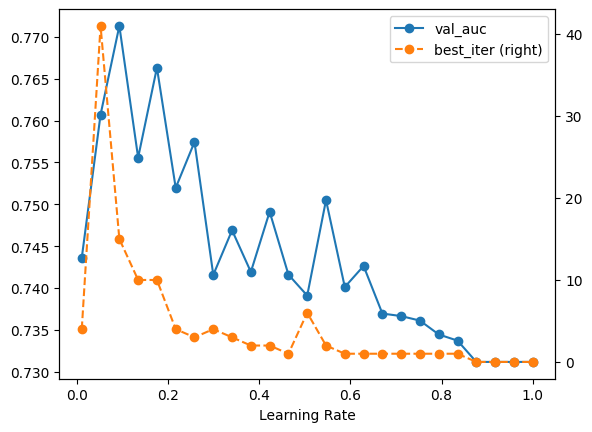

In [21]:
learning_rate_df.set_index('learning_rate').plot(secondary_y='best_iter', style=['-o', '--o'], xlabel='Learning Rate');

It looks like smaller learning rates, as long as they're not too small, give us the best performance.

Our best ROC AUC score is:

In [22]:
max(val_aucs)

0.7712970684456989

Which, is a bit better than what we found above. Hooray!

Determine the learning rate and number of trees used for the best ROC AUC score above.

In [24]:
### YOUR CODE HERE ###
max_auc = max(val_aucs)
max_auc_index = val_aucs.index(max_auc)
best_learning_rate = learning_rates[max_auc_index]
best_num_trees = best_iters[max_auc_index]
print(f"Best Learning Rate: {best_learning_rate}")
print(f"Best Number of Trees: {best_num_trees}")

Best Learning Rate: 0.0925
Best Number of Trees: 15


### Parameter Search

The learning rate and early stopping rounds aren't the only hyperparameters that we can play with here. Here are some others:

* *max_depth* - The maximum depth to which trees within the ensemble can be grown.
* *gamma* - Limits the complexity of trees in the ensemble by only allowing a node to be split if the reduction in the loss function is greater than a certain amount.
* *min_child_weight* - Controls the complexity of trees by only splitting nodes if they have at least a certain amount of "sample weight". If all samples have equal weighting, this equates to a minimum number of training samples in a node.
* *colsample_bytree* - This is a randomly selected fraction of features that are used to grow each tree in the ensemble.
* *subsample* - Controls what fraction of samples from the training data is randomly selected prior to growing a new tree for the ensemble.



We'll now create a parameter grid with different possible values for these parameters. For the ordinal parameters, we'll specify a range, while for the numeric ones will just use a uniform sample.

In [25]:
param_grid = {'max_depth': [2,3,4,5,6,7],
              'gamma':uniform(loc=0.0, scale = 3),
              'min_child_weight':list(range(1,151)),
              'colsample_bytree':uniform(loc = 0.1, scale = 0.9),
              'subsample':uniform(loc=0.5, scale = 0.5),
              'learning_rate':uniform(loc=0.01, scale = 0.5),
              }

Now, we'll create a list of 1,000 samples from the param_grid above.

In [26]:
rng = np.random.RandomState(6600)
n_iter = 1000
param_list = list(ParameterSampler(param_grid, n_iter, random_state = rng))

For example, our first random sample is:

In [27]:
param_list[0]

{'colsample_bytree': 0.2792456627458437,
 'gamma': 2.9653930463578906,
 'learning_rate': 0.46566911647102255,
 'max_depth': 3,
 'min_child_weight': 8,
 'subsample': 0.577004433672033}

Now, we also want to specify our objective function and evaluation metric as part of our parameters, so we can expand our parameters with:

In [28]:
param_list[0]['objective'] = 'binary:logistic'
param_list[0]['eval_metric'] = 'auc'

Now, we should have the parameters we need:

In [29]:
param_list[0]

{'colsample_bytree': 0.2792456627458437,
 'gamma': 2.9653930463578906,
 'learning_rate': 0.46566911647102255,
 'max_depth': 3,
 'min_child_weight': 8,
 'subsample': 0.577004433672033,
 'objective': 'binary:logistic',
 'eval_metric': 'auc'}

We can train a model using this set of parameters:

In [30]:
xgb_model_2 = xgb.train(param_list[0], dtrain=dtrain, num_boost_round=1000, early_stopping_rounds=30, evals=[(dtrain, 'train'), (dval, 'val')])

[0]	train-auc:0.58162	val-auc:0.56806
[1]	train-auc:0.60715	val-auc:0.55886
[2]	train-auc:0.62185	val-auc:0.57417
[3]	train-auc:0.65081	val-auc:0.59406
[4]	train-auc:0.65262	val-auc:0.57417
[5]	train-auc:0.65637	val-auc:0.58018
[6]	train-auc:0.66047	val-auc:0.58289
[7]	train-auc:0.66948	val-auc:0.57421
[8]	train-auc:0.67768	val-auc:0.57659
[9]	train-auc:0.72481	val-auc:0.64205
[10]	train-auc:0.72796	val-auc:0.63649
[11]	train-auc:0.73347	val-auc:0.63613
[12]	train-auc:0.73726	val-auc:0.63422
[13]	train-auc:0.74766	val-auc:0.64696
[14]	train-auc:0.75157	val-auc:0.64732
[15]	train-auc:0.75842	val-auc:0.64044
[16]	train-auc:0.76019	val-auc:0.63671
[17]	train-auc:0.76412	val-auc:0.64030
[18]	train-auc:0.76621	val-auc:0.64183
[19]	train-auc:0.76913	val-auc:0.63500
[20]	train-auc:0.77072	val-auc:0.63007
[21]	train-auc:0.77549	val-auc:0.62888
[22]	train-auc:0.77738	val-auc:0.63095
[23]	train-auc:0.77928	val-auc:0.62749
[24]	train-auc:0.78471	val-auc:0.62086
[25]	train-auc:0.78745	val-auc:0.61

Now, what you should do is go through all the parameter combinations in our grid and figure out what the best model (best stopping time for highest validation ROC AUC) for each of them. Then, determine the optimal parameter combination. Note this might take a couple minutes to run.

In [ ]:
val_aucs = []
for params in param_list:
  ### YOUR CODE HERE ###
    params['objective'] = 'binary:logistic'
    params['eval_metric'] = 'auc'

    # Train XGBoost model with early stopping
    xgb_model = xgb.train(params, dtrain=dtrain, num_boost_round=1000,
                          early_stopping_rounds=30, evals=[(dtrain, 'train'), (dval, 'val')],
                          verbose_eval=False)

    val_set_pred_prob = xgb_model.predict(dval, iteration_range=(0, xgb_model.best_iteration + 1))

    # Calculate and store validation ROC AUC
    val_auc = roc_auc_score(y_val, val_set_pred_prob)
    val_aucs.append(val_auc)


Let's create a dataframe from the various parameters, and add a column with the corresponding ROC AUC scores for the best XGBoost models.

In [32]:
xgb_param_search_df = pd.DataFrame(param_list)
xgb_param_search_df['Validation ROC AUC'] = val_aucs
xgb_param_search_df.head()

,colsample_bytree,gamma,learning_rate,max_depth,min_child_weight,subsample,objective,eval_metric,Validation ROC AUC
0,0.279246,2.965393,0.465669,3,8,0.577004,binary:logistic,auc,0.670565
1,0.464960,0.176980,0.395888,3,20,0.795599,binary:logistic,auc,0.737164
2,0.751689,2.221332,0.062536,5,93,0.503705,binary:logistic,auc,0.725925
3,0.777785,2.790733,0.120128,6,142,0.517629,binary:logistic,auc,0.710717
4,0.794387,0.217399,0.267152,4,104,0.919446,binary:logistic,auc,0.728061


Determine the parameter set with the best ROC AUC score. What can you say about it?

In [33]:
### YOUR CODE HERE ###
best_roc_auc = xgb_param_search_df['Validation ROC AUC'].max()
best_param_row = xgb_param_search_df[xgb_param_search_df['Validation ROC AUC'] == best_roc_auc]
best_params = best_param_row.drop(columns=['Validation ROC AUC']).iloc[0].to_dict()
print(best_params)

{'colsample_bytree': 0.6260970518554606, 'gamma': 2.279187079807467, 'learning_rate': 0.19044150619652406, 'max_depth': 7, 'min_child_weight': 1, 'subsample': 0.9007100657126261, 'objective': 'binary:logistic', 'eval_metric': 'auc'}
